## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.utils.extmath import randomized_svd as rsvd

from utils import tic, toc, hankel_matrix, scaler, legendre_polys, find_opt_lag, generate_color_gradient
from models import linear_regression, VAE

%matplotlib inline

2025-01-07 14:43:37.585955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 14:43:37.716021: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 14:43:38.204502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-01-07 14:43:38.204583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
from numpy.random import seed
seed(1)
keras.utils.set_random_seed(1)

In [3]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [4]:
figdir = '/home/ryanr/Allen/arousal_final/figs'

## Define SDE functions

In [5]:
## Adapted from: https://github.com/mattja/sdeint

def itoEuler(f, G, y0, tspan, sigma=10, rho=28, b=2.667, omega=0, dW=None, generator=None):

    generator = np.random.default_rng()
    N = len(tspan)
    h = (tspan[N-1] - tspan[0])/(N - 1)
    d = len(y0)
    # allocate space for result
    y = np.zeros((N, d), dtype=y0.dtype)
    
    if dW is None:
        # pre-generate Wiener increments (for m independent Wiener processes):
        #dW = deltaW(N - 1, m, h, generator)
        dW = generator.normal(0.0, np.sqrt(h), (N-1, d))

    y[0] = y0
    for n in range(0, N-2):
        tn = tspan[n]
        yn = y[n]
        dWn = dW[n,:]
        y[n+1] = yn + f(yn, tn, sigma, rho, b) * h + G(yn, tn, omega).dot(dWn)
    return y

In [6]:
def lorenz(X, t, sigma=10, rho=28, b=2.667):

    x = X[0]
    y = X[1]
    z = X[2]
    x_dot = sigma*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - b*z
    
    return np.array([x_dot, y_dot, z_dot])
    
def G(x, t, omega=0):
    B = np.diag([omega, omega, omega])
    return B

## Simulate (zero noise for now)

In [7]:
dt = .01
num_steps = 10000
t = np.linspace(0., dt*num_steps, num_steps)
x0 = np.array([0., 1., 1.])

# Lorenz params
rho = 28
sigma = 10
b=2.667

sim = itoEuler(lorenz, G, x0, t, sigma, rho, b, omega=0)

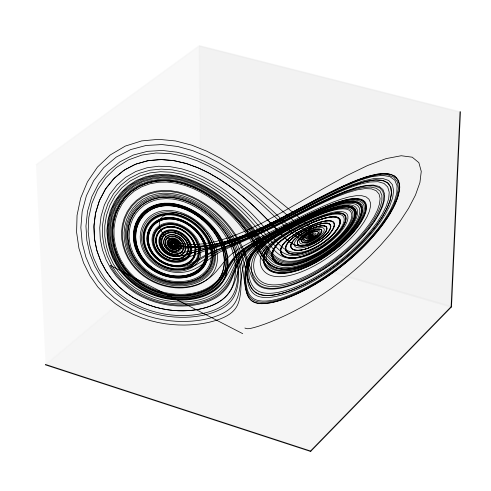

In [8]:
# Plot
fig = plt.figure(layout='compressed')
ax = fig.add_subplot(projection='3d')
ax.plot(sim[:,0], sim[:,1], sim[:,2], 'k', lw=.5)

# ax.set_xlabel('$z_1$')
# ax.set_ylabel('$z_2$')
# ax.set_zlabel('$z_3$')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.savefig(figdir + '/lorenz_3d_clean.pdf', dpi=300, transparent=True)

plt.show()

# Parameter sweep

In [9]:
## Set modeling parameters

dt = .01
stackmax = 40 # Hankel row dimension (i.e., number of time shifts)
spacing = 1 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 6 # number of latent dimensions used for VAE
num_epochs = 200 # number of training epochs
lr = .01 # learning rate
beta = .1 # beta weight for KL loss in VAE training
anneal_step = 2000 # determines rate at which KL loss is increased during training

## Set Lorenz parameters
rho = 28
sigma = 10
b=2.667
num_steps = 10000

## Dynamical noise

In [10]:
nsamples = 6000
num_runs = 8

subjects = np.tile([0., 1., 1.], (num_runs, 1))

scores = np.zeros([len(subjects),4])

for s in range(num_runs):
    
    tic()
    
    alpha_param = 3*s
    beta_param = 0#3*s

    t = np.linspace(0.0, dt*num_steps, num_steps)
    x0 = np.array([0., 1., 1.])

    sim = itoEuler(lorenz, G, subjects[s,:], t, omega=alpha_param) + np.random.normal(scale=beta_param, size=sim.shape)
        
    x = sim[:,1:2] # z2
    y = sim[:,[0,2]] # z1 & z3
    
    for m in range(4):
        if m==0:
            delay = 0
            nonlinear = 0
        elif m==1:
            delay = 0
            nonlinear = 1
        elif m==2:
            delay = 1
            nonlinear = 0
        else:
            delay = 1
            nonlinear = 1
    
        # Train-test split
        xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=x.shape[0]-nsamples,shuffle=False)
        
        # Time delay embedding    
        polys = legendre_polys(r, stackmax)

        H_train = hankel_matrix(xtrain.T,stackmax,spacing)
        H_test = hankel_matrix(xtest.T,stackmax,spacing)

        xtrain = H_train.T@polys
        xtest = H_test.T@polys

        xtrain = np.concatenate((xtrain,H_train.T[:,-1:]), axis=1)
        xtest = np.concatenate((xtest,H_test.T[:,-1:]), axis=1)
        
        ytrain = ytrain[spacing*(stackmax-1):,:]
        ytest = ytest[spacing*(stackmax-1):,:]

        if not delay:
            xtrain = xtrain[:,-1:]
            xtest = xtest[:,-1:]
        
        # Preprocessing    
        xtrain_sc, scale_x = scaler(xtrain)
        ytrain_sc, scale_y = scaler(ytrain)

        # Train model
        if nonlinear:
            r_squared, model, encoder, decoder = VAE(xtrain_sc, ytrain_sc, latent_dim=z_n, beta=beta,
                                                     num_epochs=num_epochs, anneal_step=anneal_step, lr=lr,
                                                     verbose=True)
        else:
            r_squared, model = linear_regression(xtrain_sc, ytrain_sc)

        # Test model
        xtest_sc,_ = scaler(xtest, scale_x)

        ytest_hat_sc = model.predict(xtest_sc)
        ytest_hat = scale_y.inverse_transform(ytest_hat_sc)
        
        scores[s,m] = r2_score(ytest, ytest_hat, multioutput = 'variance_weighted')

    toc()
    

2025-01-07 14:43:40.163836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 14:43:42.057782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9627 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2025-01-07 14:43:42.058553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9627 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2025-01-07 14:43:42.059145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/repli

Epoch 1/200
6/6 [==============================] - 1s 5ms/step - loss: 0.6762 - reconstruction_loss: 0.6405 - kl_loss: 1.6287e-05 - kl_anneal: 1.4286e-04
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5830 - reconstruction_loss: 0.5981 - kl_loss: 5.6375e-05 - kl_anneal: 4.4286e-04
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5922 - reconstruction_loss: 0.5895 - kl_loss: 9.4650e-05 - kl_anneal: 7.4286e-04
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5796 - reconstruction_loss: 0.5825 - kl_loss: 1.3291e-04 - kl_anneal: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5969 - reconstruction_loss: 0.5809 - kl_loss: 1.8323e-04 - kl_anneal: 0.0013
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5790 - reconstruction_loss: 0.5792 - kl_loss: 2.4590e-04 - kl_anneal: 0.0016
Epoch 7/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5948 - reconstr

6/6 [==============================] - 0s 6ms/step - loss: 0.5802 - reconstruction_loss: 0.5713 - kl_loss: 0.0031 - kl_anneal: 0.0166
Epoch 57/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5772 - reconstruction_loss: 0.5724 - kl_loss: 0.0031 - kl_anneal: 0.0169
Epoch 58/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5612 - reconstruction_loss: 0.5721 - kl_loss: 0.0031 - kl_anneal: 0.0172
Epoch 59/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5910 - reconstruction_loss: 0.5726 - kl_loss: 0.0031 - kl_anneal: 0.0175
Epoch 60/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5824 - reconstruction_loss: 0.5703 - kl_loss: 0.0032 - kl_anneal: 0.0178
Epoch 61/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5697 - reconstruction_loss: 0.5713 - kl_loss: 0.0032 - kl_anneal: 0.0181
Epoch 62/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5655 - reconstruction_loss: 0.5712 - kl_loss: 0.0033 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.5680 - reconstruction_loss: 0.5727 - kl_loss: 0.0036 - kl_anneal: 0.0331
Epoch 112/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5733 - reconstruction_loss: 0.5725 - kl_loss: 0.0037 - kl_anneal: 0.0334
Epoch 113/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5941 - reconstruction_loss: 0.5714 - kl_loss: 0.0037 - kl_anneal: 0.0337
Epoch 114/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5817 - reconstruction_loss: 0.5732 - kl_loss: 0.0036 - kl_anneal: 0.0340
Epoch 115/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5694 - reconstruction_loss: 0.5712 - kl_loss: 0.0037 - kl_anneal: 0.0343
Epoch 116/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5801 - reconstruction_loss: 0.5718 - kl_loss: 0.0038 - kl_anneal: 0.0346
Epoch 117/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5789 - reconstruction_loss: 0.5720 - kl_loss: 0.003

6/6 [==============================] - 0s 5ms/step - loss: 0.5855 - reconstruction_loss: 0.5731 - kl_loss: 0.0040 - kl_anneal: 0.0496
Epoch 167/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5809 - reconstruction_loss: 0.5736 - kl_loss: 0.0041 - kl_anneal: 0.0499
Epoch 168/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5835 - reconstruction_loss: 0.5719 - kl_loss: 0.0041 - kl_anneal: 0.0502
Epoch 169/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5834 - reconstruction_loss: 0.5714 - kl_loss: 0.0041 - kl_anneal: 0.0505
Epoch 170/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5740 - reconstruction_loss: 0.5716 - kl_loss: 0.0042 - kl_anneal: 0.0508
Epoch 171/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5699 - reconstruction_loss: 0.5721 - kl_loss: 0.0041 - kl_anneal: 0.0511
Epoch 172/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5716 - reconstruction_loss: 0.5719 - kl_loss: 0.004

6/6 [==============================] - 0s 6ms/step - loss: 0.0631 - reconstruction_loss: 0.0570 - kl_loss: 0.0046 - kl_anneal: 0.0061
Epoch 22/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0569 - reconstruction_loss: 0.0518 - kl_loss: 0.0049 - kl_anneal: 0.0064
Epoch 23/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0521 - reconstruction_loss: 0.0470 - kl_loss: 0.0053 - kl_anneal: 0.0067
Epoch 24/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0480 - reconstruction_loss: 0.0428 - kl_loss: 0.0056 - kl_anneal: 0.0070
Epoch 25/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0488 - reconstruction_loss: 0.0399 - kl_loss: 0.0059 - kl_anneal: 0.0073
Epoch 26/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0421 - reconstruction_loss: 0.0366 - kl_loss: 0.0062 - kl_anneal: 0.0076
Epoch 27/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0399 - reconstruction_loss: 0.0334 - kl_loss: 0.0066 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.0267 - reconstruction_loss: 0.0153 - kl_loss: 0.0115 - kl_anneal: 0.0226
Epoch 77/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0266 - reconstruction_loss: 0.0150 - kl_loss: 0.0115 - kl_anneal: 0.0229
Epoch 78/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0264 - reconstruction_loss: 0.0149 - kl_loss: 0.0115 - kl_anneal: 0.0232
Epoch 79/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0267 - reconstruction_loss: 0.0154 - kl_loss: 0.0114 - kl_anneal: 0.0235
Epoch 80/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0269 - reconstruction_loss: 0.0154 - kl_loss: 0.0115 - kl_anneal: 0.0238
Epoch 81/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0264 - reconstruction_loss: 0.0151 - kl_loss: 0.0115 - kl_anneal: 0.0241
Epoch 82/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0266 - reconstruction_loss: 0.0148 - kl_loss: 0.0115 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.0250 - reconstruction_loss: 0.0143 - kl_loss: 0.0113 - kl_anneal: 0.0391
Epoch 132/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0259 - reconstruction_loss: 0.0148 - kl_loss: 0.0112 - kl_anneal: 0.0394
Epoch 133/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0255 - reconstruction_loss: 0.0142 - kl_loss: 0.0112 - kl_anneal: 0.0397
Epoch 134/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0255 - reconstruction_loss: 0.0144 - kl_loss: 0.0113 - kl_anneal: 0.0400
Epoch 135/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0255 - reconstruction_loss: 0.0144 - kl_loss: 0.0113 - kl_anneal: 0.0403
Epoch 136/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0252 - reconstruction_loss: 0.0138 - kl_loss: 0.0113 - kl_anneal: 0.0406
Epoch 137/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0254 - reconstruction_loss: 0.0144 - kl_loss: 0.011

6/6 [==============================] - 0s 6ms/step - loss: 0.0248 - reconstruction_loss: 0.0138 - kl_loss: 0.0111 - kl_anneal: 0.0556
Epoch 187/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0246 - reconstruction_loss: 0.0140 - kl_loss: 0.0110 - kl_anneal: 0.0559
Epoch 188/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0250 - reconstruction_loss: 0.0140 - kl_loss: 0.0110 - kl_anneal: 0.0562
Epoch 189/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0248 - reconstruction_loss: 0.0140 - kl_loss: 0.0110 - kl_anneal: 0.0565
Epoch 190/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0258 - reconstruction_loss: 0.0141 - kl_loss: 0.0110 - kl_anneal: 0.0568
Epoch 191/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0256 - reconstruction_loss: 0.0142 - kl_loss: 0.0111 - kl_anneal: 0.0571
Epoch 192/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0255 - reconstruction_loss: 0.0141 - kl_loss: 0.011

6/6 [==============================] - 0s 6ms/step - loss: 0.6088 - reconstruction_loss: 0.6143 - kl_loss: 0.0023 - kl_anneal: 0.0118
Epoch 41/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6204 - reconstruction_loss: 0.6147 - kl_loss: 0.0023 - kl_anneal: 0.0121
Epoch 42/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6130 - reconstruction_loss: 0.6141 - kl_loss: 0.0023 - kl_anneal: 0.0124
Epoch 43/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6216 - reconstruction_loss: 0.6146 - kl_loss: 0.0023 - kl_anneal: 0.0127
Epoch 44/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6061 - reconstruction_loss: 0.6138 - kl_loss: 0.0023 - kl_anneal: 0.0130
Epoch 45/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6157 - reconstruction_loss: 0.6149 - kl_loss: 0.0023 - kl_anneal: 0.0133
Epoch 46/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6122 - reconstruction_loss: 0.6150 - kl_loss: 0.0023 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.6149 - reconstruction_loss: 0.6152 - kl_loss: 0.0030 - kl_anneal: 0.0283
Epoch 96/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6148 - reconstruction_loss: 0.6148 - kl_loss: 0.0030 - kl_anneal: 0.0286
Epoch 97/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6159 - reconstruction_loss: 0.6149 - kl_loss: 0.0031 - kl_anneal: 0.0289
Epoch 98/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6347 - reconstruction_loss: 0.6149 - kl_loss: 0.0030 - kl_anneal: 0.0292
Epoch 99/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6254 - reconstruction_loss: 0.6143 - kl_loss: 0.0031 - kl_anneal: 0.0295
Epoch 100/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6172 - reconstruction_loss: 0.6147 - kl_loss: 0.0031 - kl_anneal: 0.0298
Epoch 101/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6015 - reconstruction_loss: 0.6149 - kl_loss: 0.0031 - 

6/6 [==============================] - 0s 6ms/step - loss: 0.6114 - reconstruction_loss: 0.6155 - kl_loss: 0.0039 - kl_anneal: 0.0448
Epoch 151/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6212 - reconstruction_loss: 0.6147 - kl_loss: 0.0040 - kl_anneal: 0.0451
Epoch 152/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6117 - reconstruction_loss: 0.6154 - kl_loss: 0.0040 - kl_anneal: 0.0454
Epoch 153/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6098 - reconstruction_loss: 0.6148 - kl_loss: 0.0040 - kl_anneal: 0.0457
Epoch 154/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6169 - reconstruction_loss: 0.6147 - kl_loss: 0.0038 - kl_anneal: 0.0460
Epoch 155/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6208 - reconstruction_loss: 0.6148 - kl_loss: 0.0039 - kl_anneal: 0.0463
Epoch 156/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6225 - reconstruction_loss: 0.6154 - kl_loss: 0.003

6/6 [==============================] - 0s 5ms/step - loss: 0.4233 - reconstruction_loss: 0.4080 - kl_loss: 5.0776e-04 - kl_anneal: 0.0013
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3645 - reconstruction_loss: 0.3503 - kl_loss: 6.5681e-04 - kl_anneal: 0.0016
Epoch 7/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3030 - reconstruction_loss: 0.2950 - kl_loss: 8.7318e-04 - kl_anneal: 0.0019
Epoch 8/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2529 - reconstruction_loss: 0.2424 - kl_loss: 0.0011 - kl_anneal: 0.0022
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2044 - reconstruction_loss: 0.1936 - kl_loss: 0.0014 - kl_anneal: 0.0025
Epoch 10/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1622 - reconstruction_loss: 0.1523 - kl_loss: 0.0017 - kl_anneal: 0.0028
Epoch 11/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1295 - reconstruction_loss: 0.1214 - kl_loss: 0.0

6/6 [==============================] - 0s 6ms/step - loss: 0.0384 - reconstruction_loss: 0.0279 - kl_loss: 0.0106 - kl_anneal: 0.0178
Epoch 61/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0381 - reconstruction_loss: 0.0278 - kl_loss: 0.0106 - kl_anneal: 0.0181
Epoch 62/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0388 - reconstruction_loss: 0.0281 - kl_loss: 0.0106 - kl_anneal: 0.0184
Epoch 63/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0380 - reconstruction_loss: 0.0275 - kl_loss: 0.0107 - kl_anneal: 0.0187
Epoch 64/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0390 - reconstruction_loss: 0.0279 - kl_loss: 0.0107 - kl_anneal: 0.0190
Epoch 65/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0385 - reconstruction_loss: 0.0276 - kl_loss: 0.0107 - kl_anneal: 0.0193
Epoch 66/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0381 - reconstruction_loss: 0.0276 - kl_loss: 0.0107 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.0400 - reconstruction_loss: 0.0278 - kl_loss: 0.0117 - kl_anneal: 0.0343
Epoch 116/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0393 - reconstruction_loss: 0.0274 - kl_loss: 0.0117 - kl_anneal: 0.0346
Epoch 117/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0393 - reconstruction_loss: 0.0277 - kl_loss: 0.0115 - kl_anneal: 0.0349
Epoch 118/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0394 - reconstruction_loss: 0.0281 - kl_loss: 0.0114 - kl_anneal: 0.0352
Epoch 119/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0389 - reconstruction_loss: 0.0279 - kl_loss: 0.0114 - kl_anneal: 0.0355
Epoch 120/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0400 - reconstruction_loss: 0.0282 - kl_loss: 0.0114 - kl_anneal: 0.0358
Epoch 121/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0391 - reconstruction_loss: 0.0275 - kl_loss: 0.011

6/6 [==============================] - 0s 6ms/step - loss: 0.0393 - reconstruction_loss: 0.0286 - kl_loss: 0.0106 - kl_anneal: 0.0508
Epoch 171/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0399 - reconstruction_loss: 0.0289 - kl_loss: 0.0108 - kl_anneal: 0.0511
Epoch 172/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0396 - reconstruction_loss: 0.0290 - kl_loss: 0.0108 - kl_anneal: 0.0514
Epoch 173/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0395 - reconstruction_loss: 0.0287 - kl_loss: 0.0106 - kl_anneal: 0.0517
Epoch 174/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0393 - reconstruction_loss: 0.0285 - kl_loss: 0.0106 - kl_anneal: 0.0520
Epoch 175/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0385 - reconstruction_loss: 0.0285 - kl_loss: 0.0105 - kl_anneal: 0.0523
Epoch 176/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0388 - reconstruction_loss: 0.0283 - kl_loss: 0.010

6/6 [==============================] - 0s 6ms/step - loss: 0.6331 - reconstruction_loss: 0.6445 - kl_loss: 0.0020 - kl_anneal: 0.0070
Epoch 25/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6507 - reconstruction_loss: 0.6442 - kl_loss: 0.0021 - kl_anneal: 0.0073
Epoch 26/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6408 - reconstruction_loss: 0.6467 - kl_loss: 0.0021 - kl_anneal: 0.0076
Epoch 27/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6375 - reconstruction_loss: 0.6446 - kl_loss: 0.0022 - kl_anneal: 0.0079
Epoch 28/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6437 - reconstruction_loss: 0.6435 - kl_loss: 0.0023 - kl_anneal: 0.0082
Epoch 29/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6385 - reconstruction_loss: 0.6449 - kl_loss: 0.0024 - kl_anneal: 0.0085
Epoch 30/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6473 - reconstruction_loss: 0.6453 - kl_loss: 0.0024 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.6489 - reconstruction_loss: 0.6454 - kl_loss: 0.0027 - kl_anneal: 0.0235
Epoch 80/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6535 - reconstruction_loss: 0.6446 - kl_loss: 0.0028 - kl_anneal: 0.0238
Epoch 81/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6386 - reconstruction_loss: 0.6449 - kl_loss: 0.0028 - kl_anneal: 0.0241
Epoch 82/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6435 - reconstruction_loss: 0.6452 - kl_loss: 0.0028 - kl_anneal: 0.0244
Epoch 83/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6605 - reconstruction_loss: 0.6449 - kl_loss: 0.0029 - kl_anneal: 0.0247
Epoch 84/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6530 - reconstruction_loss: 0.6448 - kl_loss: 0.0029 - kl_anneal: 0.0250
Epoch 85/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6351 - reconstruction_loss: 0.6444 - kl_loss: 0.0029 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.6500 - reconstruction_loss: 0.6449 - kl_loss: 0.0035 - kl_anneal: 0.0400
Epoch 135/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6407 - reconstruction_loss: 0.6438 - kl_loss: 0.0035 - kl_anneal: 0.0403
Epoch 136/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6459 - reconstruction_loss: 0.6458 - kl_loss: 0.0034 - kl_anneal: 0.0406
Epoch 137/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6507 - reconstruction_loss: 0.6454 - kl_loss: 0.0033 - kl_anneal: 0.0409
Epoch 138/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6424 - reconstruction_loss: 0.6462 - kl_loss: 0.0034 - kl_anneal: 0.0412
Epoch 139/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6493 - reconstruction_loss: 0.6459 - kl_loss: 0.0032 - kl_anneal: 0.0415
Epoch 140/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6465 - reconstruction_loss: 0.6445 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.6671 - reconstruction_loss: 0.6461 - kl_loss: 0.0040 - kl_anneal: 0.0565
Epoch 190/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6521 - reconstruction_loss: 0.6461 - kl_loss: 0.0041 - kl_anneal: 0.0568
Epoch 191/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6434 - reconstruction_loss: 0.6453 - kl_loss: 0.0041 - kl_anneal: 0.0571
Epoch 192/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6479 - reconstruction_loss: 0.6470 - kl_loss: 0.0040 - kl_anneal: 0.0574
Epoch 193/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6461 - reconstruction_loss: 0.6449 - kl_loss: 0.0041 - kl_anneal: 0.0577
Epoch 194/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6563 - reconstruction_loss: 0.6451 - kl_loss: 0.0041 - kl_anneal: 0.0580
Epoch 195/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6500 - reconstruction_loss: 0.6452 - kl_loss: 0.004

6/6 [==============================] - 0s 6ms/step - loss: 0.0706 - reconstruction_loss: 0.0607 - kl_loss: 0.0097 - kl_anneal: 0.0130
Epoch 45/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0705 - reconstruction_loss: 0.0602 - kl_loss: 0.0098 - kl_anneal: 0.0133
Epoch 46/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0689 - reconstruction_loss: 0.0597 - kl_loss: 0.0100 - kl_anneal: 0.0136
Epoch 47/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0685 - reconstruction_loss: 0.0594 - kl_loss: 0.0101 - kl_anneal: 0.0139
Epoch 48/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0700 - reconstruction_loss: 0.0594 - kl_loss: 0.0102 - kl_anneal: 0.0142
Epoch 49/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0705 - reconstruction_loss: 0.0602 - kl_loss: 0.0102 - kl_anneal: 0.0145
Epoch 50/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0703 - reconstruction_loss: 0.0598 - kl_loss: 0.0103 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.0708 - reconstruction_loss: 0.0589 - kl_loss: 0.0121 - kl_anneal: 0.0295
Epoch 100/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0717 - reconstruction_loss: 0.0591 - kl_loss: 0.0124 - kl_anneal: 0.0298
Epoch 101/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0700 - reconstruction_loss: 0.0582 - kl_loss: 0.0124 - kl_anneal: 0.0301
Epoch 102/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0701 - reconstruction_loss: 0.0584 - kl_loss: 0.0123 - kl_anneal: 0.0304
Epoch 103/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0712 - reconstruction_loss: 0.0585 - kl_loss: 0.0121 - kl_anneal: 0.0307
Epoch 104/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0712 - reconstruction_loss: 0.0586 - kl_loss: 0.0121 - kl_anneal: 0.0310
Epoch 105/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0712 - reconstruction_loss: 0.0587 - kl_loss: 0.012

6/6 [==============================] - 0s 6ms/step - loss: 0.0722 - reconstruction_loss: 0.0590 - kl_loss: 0.0129 - kl_anneal: 0.0460
Epoch 155/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0706 - reconstruction_loss: 0.0575 - kl_loss: 0.0130 - kl_anneal: 0.0463
Epoch 156/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0697 - reconstruction_loss: 0.0583 - kl_loss: 0.0130 - kl_anneal: 0.0466
Epoch 157/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0723 - reconstruction_loss: 0.0591 - kl_loss: 0.0130 - kl_anneal: 0.0469
Epoch 158/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0716 - reconstruction_loss: 0.0587 - kl_loss: 0.0131 - kl_anneal: 0.0472
Epoch 159/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0725 - reconstruction_loss: 0.0596 - kl_loss: 0.0131 - kl_anneal: 0.0475
Epoch 160/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0731 - reconstruction_loss: 0.0587 - kl_loss: 0.013

6/6 [==============================] - 0s 6ms/step - loss: 0.6899 - reconstruction_loss: 0.6962 - kl_loss: 1.5735e-04 - kl_anneal: 0.0022
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7026 - reconstruction_loss: 0.6951 - kl_loss: 1.9935e-04 - kl_anneal: 0.0025
Epoch 10/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7026 - reconstruction_loss: 0.6922 - kl_loss: 2.3996e-04 - kl_anneal: 0.0028
Epoch 11/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6846 - reconstruction_loss: 0.6930 - kl_loss: 2.9540e-04 - kl_anneal: 0.0031
Epoch 12/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6906 - reconstruction_loss: 0.6916 - kl_loss: 3.6190e-04 - kl_anneal: 0.0034
Epoch 13/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6877 - reconstruction_loss: 0.6919 - kl_loss: 4.3448e-04 - kl_anneal: 0.0037
Epoch 14/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6913 - reconstruction_loss: 0.6918

6/6 [==============================] - 0s 6ms/step - loss: 0.6972 - reconstruction_loss: 0.6872 - kl_loss: 0.0023 - kl_anneal: 0.0187
Epoch 64/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6980 - reconstruction_loss: 0.6867 - kl_loss: 0.0023 - kl_anneal: 0.0190
Epoch 65/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6797 - reconstruction_loss: 0.6876 - kl_loss: 0.0024 - kl_anneal: 0.0193
Epoch 66/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6830 - reconstruction_loss: 0.6866 - kl_loss: 0.0024 - kl_anneal: 0.0196
Epoch 67/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7033 - reconstruction_loss: 0.6883 - kl_loss: 0.0024 - kl_anneal: 0.0199
Epoch 68/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6844 - reconstruction_loss: 0.6875 - kl_loss: 0.0024 - kl_anneal: 0.0202
Epoch 69/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6840 - reconstruction_loss: 0.6889 - kl_loss: 0.0024 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.6868 - reconstruction_loss: 0.6857 - kl_loss: 0.0031 - kl_anneal: 0.0352
Epoch 119/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6858 - reconstruction_loss: 0.6864 - kl_loss: 0.0030 - kl_anneal: 0.0355
Epoch 120/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6880 - reconstruction_loss: 0.6879 - kl_loss: 0.0031 - kl_anneal: 0.0358
Epoch 121/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6768 - reconstruction_loss: 0.6865 - kl_loss: 0.0031 - kl_anneal: 0.0361
Epoch 122/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6781 - reconstruction_loss: 0.6873 - kl_loss: 0.0031 - kl_anneal: 0.0364
Epoch 123/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6908 - reconstruction_loss: 0.6873 - kl_loss: 0.0032 - kl_anneal: 0.0367
Epoch 124/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6807 - reconstruction_loss: 0.6874 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.7002 - reconstruction_loss: 0.6877 - kl_loss: 0.0039 - kl_anneal: 0.0517
Epoch 174/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6948 - reconstruction_loss: 0.6865 - kl_loss: 0.0037 - kl_anneal: 0.0520
Epoch 175/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6912 - reconstruction_loss: 0.6874 - kl_loss: 0.0038 - kl_anneal: 0.0523
Epoch 176/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6887 - reconstruction_loss: 0.6874 - kl_loss: 0.0037 - kl_anneal: 0.0526
Epoch 177/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6901 - reconstruction_loss: 0.6856 - kl_loss: 0.0039 - kl_anneal: 0.0529
Epoch 178/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6870 - reconstruction_loss: 0.6874 - kl_loss: 0.0038 - kl_anneal: 0.0532
Epoch 179/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6942 - reconstruction_loss: 0.6882 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.1672 - reconstruction_loss: 0.1570 - kl_loss: 0.0058 - kl_anneal: 0.0082
Epoch 29/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1587 - reconstruction_loss: 0.1541 - kl_loss: 0.0061 - kl_anneal: 0.0085
Epoch 30/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1550 - reconstruction_loss: 0.1499 - kl_loss: 0.0064 - kl_anneal: 0.0088
Epoch 31/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1532 - reconstruction_loss: 0.1465 - kl_loss: 0.0068 - kl_anneal: 0.0091
Epoch 32/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1529 - reconstruction_loss: 0.1433 - kl_loss: 0.0071 - kl_anneal: 0.0094
Epoch 33/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1462 - reconstruction_loss: 0.1396 - kl_loss: 0.0074 - kl_anneal: 0.0097
Epoch 34/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1445 - reconstruction_loss: 0.1368 - kl_loss: 0.0076 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.1210 - reconstruction_loss: 0.1085 - kl_loss: 0.0116 - kl_anneal: 0.0247
Epoch 84/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1207 - reconstruction_loss: 0.1096 - kl_loss: 0.0115 - kl_anneal: 0.0250
Epoch 85/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1201 - reconstruction_loss: 0.1086 - kl_loss: 0.0115 - kl_anneal: 0.0253
Epoch 86/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1199 - reconstruction_loss: 0.1087 - kl_loss: 0.0116 - kl_anneal: 0.0256
Epoch 87/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1186 - reconstruction_loss: 0.1079 - kl_loss: 0.0116 - kl_anneal: 0.0259
Epoch 88/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1196 - reconstruction_loss: 0.1079 - kl_loss: 0.0117 - kl_anneal: 0.0262
Epoch 89/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1202 - reconstruction_loss: 0.1083 - kl_loss: 0.0117 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.1195 - reconstruction_loss: 0.1070 - kl_loss: 0.0121 - kl_anneal: 0.0412
Epoch 139/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1190 - reconstruction_loss: 0.1068 - kl_loss: 0.0121 - kl_anneal: 0.0415
Epoch 140/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1178 - reconstruction_loss: 0.1061 - kl_loss: 0.0121 - kl_anneal: 0.0418
Epoch 141/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1176 - reconstruction_loss: 0.1059 - kl_loss: 0.0121 - kl_anneal: 0.0421
Epoch 142/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1186 - reconstruction_loss: 0.1066 - kl_loss: 0.0120 - kl_anneal: 0.0424
Epoch 143/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1200 - reconstruction_loss: 0.1078 - kl_loss: 0.0120 - kl_anneal: 0.0427
Epoch 144/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1189 - reconstruction_loss: 0.1082 - kl_loss: 0.012

6/6 [==============================] - 0s 6ms/step - loss: 0.1209 - reconstruction_loss: 0.1065 - kl_loss: 0.0126 - kl_anneal: 0.0577
Epoch 194/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1188 - reconstruction_loss: 0.1068 - kl_loss: 0.0125 - kl_anneal: 0.0580
Epoch 195/200
6/6 [==============================] - 0s 5ms/step - loss: 0.1175 - reconstruction_loss: 0.1069 - kl_loss: 0.0124 - kl_anneal: 0.0583
Epoch 196/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1204 - reconstruction_loss: 0.1067 - kl_loss: 0.0124 - kl_anneal: 0.0586
Epoch 197/200
6/6 [==============================] - 0s 5ms/step - loss: 0.1178 - reconstruction_loss: 0.1067 - kl_loss: 0.0124 - kl_anneal: 0.0589
Epoch 198/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1180 - reconstruction_loss: 0.1059 - kl_loss: 0.0124 - kl_anneal: 0.0592
Epoch 199/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1195 - reconstruction_loss: 0.1070 - kl_loss: 0.012

6/6 [==============================] - 0s 6ms/step - loss: 0.7223 - reconstruction_loss: 0.7245 - kl_loss: 0.0023 - kl_anneal: 0.0142
Epoch 49/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7242 - reconstruction_loss: 0.7237 - kl_loss: 0.0023 - kl_anneal: 0.0145
Epoch 50/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7158 - reconstruction_loss: 0.7233 - kl_loss: 0.0024 - kl_anneal: 0.0148
Epoch 51/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7149 - reconstruction_loss: 0.7244 - kl_loss: 0.0024 - kl_anneal: 0.0151
Epoch 52/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7355 - reconstruction_loss: 0.7243 - kl_loss: 0.0024 - kl_anneal: 0.0154
Epoch 53/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7127 - reconstruction_loss: 0.7246 - kl_loss: 0.0024 - kl_anneal: 0.0157
Epoch 54/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7030 - reconstruction_loss: 0.7245 - kl_loss: 0.0024 - kl

6/6 [==============================] - 0s 5ms/step - loss: 0.7180 - reconstruction_loss: 0.7236 - kl_loss: 0.0029 - kl_anneal: 0.0307
Epoch 104/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7221 - reconstruction_loss: 0.7227 - kl_loss: 0.0029 - kl_anneal: 0.0310
Epoch 105/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7417 - reconstruction_loss: 0.7237 - kl_loss: 0.0029 - kl_anneal: 0.0313
Epoch 106/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7112 - reconstruction_loss: 0.7250 - kl_loss: 0.0030 - kl_anneal: 0.0316
Epoch 107/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7155 - reconstruction_loss: 0.7242 - kl_loss: 0.0030 - kl_anneal: 0.0319
Epoch 108/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7339 - reconstruction_loss: 0.7232 - kl_loss: 0.0031 - kl_anneal: 0.0322
Epoch 109/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7209 - reconstruction_loss: 0.7228 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.7132 - reconstruction_loss: 0.7249 - kl_loss: 0.0037 - kl_anneal: 0.0472
Epoch 159/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7258 - reconstruction_loss: 0.7230 - kl_loss: 0.0039 - kl_anneal: 0.0475
Epoch 160/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7432 - reconstruction_loss: 0.7220 - kl_loss: 0.0038 - kl_anneal: 0.0478
Epoch 161/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7225 - reconstruction_loss: 0.7220 - kl_loss: 0.0038 - kl_anneal: 0.0481
Epoch 162/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7259 - reconstruction_loss: 0.7241 - kl_loss: 0.0036 - kl_anneal: 0.0484
Epoch 163/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7339 - reconstruction_loss: 0.7219 - kl_loss: 0.0038 - kl_anneal: 0.0487
Epoch 164/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7164 - reconstruction_loss: 0.7236 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.2381 - reconstruction_loss: 0.2356 - kl_loss: 0.0028 - kl_anneal: 0.0037
Epoch 14/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2342 - reconstruction_loss: 0.2271 - kl_loss: 0.0031 - kl_anneal: 0.0040
Epoch 15/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2204 - reconstruction_loss: 0.2195 - kl_loss: 0.0034 - kl_anneal: 0.0043
Epoch 16/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2151 - reconstruction_loss: 0.2123 - kl_loss: 0.0037 - kl_anneal: 0.0046
Epoch 17/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2094 - reconstruction_loss: 0.2068 - kl_loss: 0.0040 - kl_anneal: 0.0049
Epoch 18/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2015 - reconstruction_loss: 0.2007 - kl_loss: 0.0043 - kl_anneal: 0.0052
Epoch 19/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1985 - reconstruction_loss: 0.1963 - kl_loss: 0.0046 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.1573 - reconstruction_loss: 0.1472 - kl_loss: 0.0101 - kl_anneal: 0.0202
Epoch 69/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1575 - reconstruction_loss: 0.1477 - kl_loss: 0.0101 - kl_anneal: 0.0205
Epoch 70/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1616 - reconstruction_loss: 0.1482 - kl_loss: 0.0100 - kl_anneal: 0.0208
Epoch 71/200
6/6 [==============================] - 0s 5ms/step - loss: 0.1580 - reconstruction_loss: 0.1468 - kl_loss: 0.0101 - kl_anneal: 0.0211
Epoch 72/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1571 - reconstruction_loss: 0.1465 - kl_loss: 0.0102 - kl_anneal: 0.0214
Epoch 73/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1562 - reconstruction_loss: 0.1461 - kl_loss: 0.0102 - kl_anneal: 0.0217
Epoch 74/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1560 - reconstruction_loss: 0.1473 - kl_loss: 0.0101 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.1564 - reconstruction_loss: 0.1445 - kl_loss: 0.0112 - kl_anneal: 0.0367
Epoch 124/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1543 - reconstruction_loss: 0.1430 - kl_loss: 0.0112 - kl_anneal: 0.0370
Epoch 125/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1535 - reconstruction_loss: 0.1443 - kl_loss: 0.0110 - kl_anneal: 0.0373
Epoch 126/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1537 - reconstruction_loss: 0.1444 - kl_loss: 0.0112 - kl_anneal: 0.0376
Epoch 127/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1537 - reconstruction_loss: 0.1444 - kl_loss: 0.0112 - kl_anneal: 0.0379
Epoch 128/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1556 - reconstruction_loss: 0.1438 - kl_loss: 0.0114 - kl_anneal: 0.0382
Epoch 129/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1559 - reconstruction_loss: 0.1435 - kl_loss: 0.011

6/6 [==============================] - 0s 6ms/step - loss: 0.1545 - reconstruction_loss: 0.1438 - kl_loss: 0.0120 - kl_anneal: 0.0532
Epoch 179/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1550 - reconstruction_loss: 0.1427 - kl_loss: 0.0121 - kl_anneal: 0.0535
Epoch 180/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1551 - reconstruction_loss: 0.1416 - kl_loss: 0.0119 - kl_anneal: 0.0538
Epoch 181/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1547 - reconstruction_loss: 0.1436 - kl_loss: 0.0117 - kl_anneal: 0.0541
Epoch 182/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1553 - reconstruction_loss: 0.1436 - kl_loss: 0.0116 - kl_anneal: 0.0544
Epoch 183/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1561 - reconstruction_loss: 0.1437 - kl_loss: 0.0119 - kl_anneal: 0.0547
Epoch 184/200
6/6 [==============================] - 0s 6ms/step - loss: 0.1596 - reconstruction_loss: 0.1460 - kl_loss: 0.011

6/6 [==============================] - 0s 6ms/step - loss: 0.7482 - reconstruction_loss: 0.7566 - kl_loss: 0.0012 - kl_anneal: 0.0094
Epoch 33/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7565 - reconstruction_loss: 0.7568 - kl_loss: 0.0012 - kl_anneal: 0.0097
Epoch 34/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7607 - reconstruction_loss: 0.7572 - kl_loss: 0.0012 - kl_anneal: 0.0100
Epoch 35/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7498 - reconstruction_loss: 0.7569 - kl_loss: 0.0013 - kl_anneal: 0.0103
Epoch 36/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7554 - reconstruction_loss: 0.7563 - kl_loss: 0.0013 - kl_anneal: 0.0106
Epoch 37/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7645 - reconstruction_loss: 0.7567 - kl_loss: 0.0013 - kl_anneal: 0.0109
Epoch 38/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7513 - reconstruction_loss: 0.7569 - kl_loss: 0.0014 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.7810 - reconstruction_loss: 0.7556 - kl_loss: 0.0021 - kl_anneal: 0.0259
Epoch 88/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7583 - reconstruction_loss: 0.7561 - kl_loss: 0.0021 - kl_anneal: 0.0262
Epoch 89/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7738 - reconstruction_loss: 0.7569 - kl_loss: 0.0021 - kl_anneal: 0.0265
Epoch 90/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7457 - reconstruction_loss: 0.7566 - kl_loss: 0.0021 - kl_anneal: 0.0268
Epoch 91/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7618 - reconstruction_loss: 0.7572 - kl_loss: 0.0022 - kl_anneal: 0.0271
Epoch 92/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7417 - reconstruction_loss: 0.7565 - kl_loss: 0.0023 - kl_anneal: 0.0274
Epoch 93/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7629 - reconstruction_loss: 0.7567 - kl_loss: 0.0022 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.7511 - reconstruction_loss: 0.7572 - kl_loss: 0.0029 - kl_anneal: 0.0424
Epoch 143/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7613 - reconstruction_loss: 0.7556 - kl_loss: 0.0030 - kl_anneal: 0.0427
Epoch 144/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7651 - reconstruction_loss: 0.7571 - kl_loss: 0.0028 - kl_anneal: 0.0430
Epoch 145/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7686 - reconstruction_loss: 0.7566 - kl_loss: 0.0029 - kl_anneal: 0.0433
Epoch 146/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7617 - reconstruction_loss: 0.7561 - kl_loss: 0.0028 - kl_anneal: 0.0436
Epoch 147/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7711 - reconstruction_loss: 0.7561 - kl_loss: 0.0029 - kl_anneal: 0.0439
Epoch 148/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7622 - reconstruction_loss: 0.7581 - kl_loss: 0.002

6/6 [==============================] - 0s 5ms/step - loss: 0.7542 - reconstruction_loss: 0.7569 - kl_loss: 0.0035 - kl_anneal: 0.0589
Epoch 198/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7621 - reconstruction_loss: 0.7567 - kl_loss: 0.0034 - kl_anneal: 0.0592
Epoch 199/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7573 - reconstruction_loss: 0.7587 - kl_loss: 0.0034 - kl_anneal: 0.0595
Epoch 200/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7605 - reconstruction_loss: 0.7573 - kl_loss: 0.0035 - kl_anneal: 0.0598
Epoch 1/200
6/6 [==============================] - 0s 3ms/step - loss: 0.9261 - reconstruction_loss: 0.8475 - kl_loss: 4.5840e-05 - kl_anneal: 1.4286e-04
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6541 - reconstruction_loss: 0.6515 - kl_loss: 1.5324e-04 - kl_anneal: 4.4286e-04
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6136 - reconstruction_loss: 0.6125 - kl_l

6/6 [==============================] - 0s 6ms/step - loss: 0.2532 - reconstruction_loss: 0.2452 - kl_loss: 0.0092 - kl_anneal: 0.0154
Epoch 53/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2579 - reconstruction_loss: 0.2446 - kl_loss: 0.0093 - kl_anneal: 0.0157
Epoch 54/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2478 - reconstruction_loss: 0.2427 - kl_loss: 0.0094 - kl_anneal: 0.0160
Epoch 55/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2538 - reconstruction_loss: 0.2450 - kl_loss: 0.0095 - kl_anneal: 0.0163
Epoch 56/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2511 - reconstruction_loss: 0.2429 - kl_loss: 0.0096 - kl_anneal: 0.0166
Epoch 57/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2503 - reconstruction_loss: 0.2420 - kl_loss: 0.0096 - kl_anneal: 0.0169
Epoch 58/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2526 - reconstruction_loss: 0.2431 - kl_loss: 0.0096 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.2468 - reconstruction_loss: 0.2332 - kl_loss: 0.0122 - kl_anneal: 0.0319
Epoch 108/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2470 - reconstruction_loss: 0.2306 - kl_loss: 0.0122 - kl_anneal: 0.0322
Epoch 109/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2424 - reconstruction_loss: 0.2336 - kl_loss: 0.0121 - kl_anneal: 0.0325
Epoch 110/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2447 - reconstruction_loss: 0.2329 - kl_loss: 0.0122 - kl_anneal: 0.0328
Epoch 111/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2415 - reconstruction_loss: 0.2313 - kl_loss: 0.0123 - kl_anneal: 0.0331
Epoch 112/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2441 - reconstruction_loss: 0.2307 - kl_loss: 0.0124 - kl_anneal: 0.0334
Epoch 113/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2419 - reconstruction_loss: 0.2308 - kl_loss: 0.012

6/6 [==============================] - 0s 6ms/step - loss: 0.2442 - reconstruction_loss: 0.2291 - kl_loss: 0.0136 - kl_anneal: 0.0484
Epoch 163/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2412 - reconstruction_loss: 0.2266 - kl_loss: 0.0136 - kl_anneal: 0.0487
Epoch 164/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2388 - reconstruction_loss: 0.2271 - kl_loss: 0.0135 - kl_anneal: 0.0490
Epoch 165/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2411 - reconstruction_loss: 0.2268 - kl_loss: 0.0135 - kl_anneal: 0.0493
Epoch 166/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2415 - reconstruction_loss: 0.2285 - kl_loss: 0.0136 - kl_anneal: 0.0496
Epoch 167/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2378 - reconstruction_loss: 0.2272 - kl_loss: 0.0140 - kl_anneal: 0.0499
Epoch 168/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2412 - reconstruction_loss: 0.2286 - kl_loss: 0.014

6/6 [==============================] - 0s 6ms/step - loss: 0.7899 - reconstruction_loss: 0.7779 - kl_loss: 8.2239e-04 - kl_anneal: 0.0046
Epoch 17/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7764 - reconstruction_loss: 0.7771 - kl_loss: 8.9798e-04 - kl_anneal: 0.0049
Epoch 18/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7921 - reconstruction_loss: 0.7781 - kl_loss: 9.4741e-04 - kl_anneal: 0.0052
Epoch 19/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7818 - reconstruction_loss: 0.7774 - kl_loss: 0.0010 - kl_anneal: 0.0055
Epoch 20/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7697 - reconstruction_loss: 0.7789 - kl_loss: 0.0011 - kl_anneal: 0.0058
Epoch 21/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7910 - reconstruction_loss: 0.7778 - kl_loss: 0.0011 - kl_anneal: 0.0061
Epoch 22/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7792 - reconstruction_loss: 0.7783 - kl_loss:

6/6 [==============================] - 0s 6ms/step - loss: 0.7731 - reconstruction_loss: 0.7764 - kl_loss: 0.0024 - kl_anneal: 0.0211
Epoch 72/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7773 - reconstruction_loss: 0.7763 - kl_loss: 0.0024 - kl_anneal: 0.0214
Epoch 73/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7680 - reconstruction_loss: 0.7764 - kl_loss: 0.0025 - kl_anneal: 0.0217
Epoch 74/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7847 - reconstruction_loss: 0.7757 - kl_loss: 0.0024 - kl_anneal: 0.0220
Epoch 75/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7970 - reconstruction_loss: 0.7755 - kl_loss: 0.0025 - kl_anneal: 0.0223
Epoch 76/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7850 - reconstruction_loss: 0.7755 - kl_loss: 0.0025 - kl_anneal: 0.0226
Epoch 77/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7757 - reconstruction_loss: 0.7770 - kl_loss: 0.0025 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.7798 - reconstruction_loss: 0.7774 - kl_loss: 0.0031 - kl_anneal: 0.0376
Epoch 127/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7671 - reconstruction_loss: 0.7764 - kl_loss: 0.0029 - kl_anneal: 0.0379
Epoch 128/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7718 - reconstruction_loss: 0.7763 - kl_loss: 0.0030 - kl_anneal: 0.0382
Epoch 129/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7761 - reconstruction_loss: 0.7782 - kl_loss: 0.0031 - kl_anneal: 0.0385
Epoch 130/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7723 - reconstruction_loss: 0.7757 - kl_loss: 0.0031 - kl_anneal: 0.0388
Epoch 131/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7732 - reconstruction_loss: 0.7777 - kl_loss: 0.0032 - kl_anneal: 0.0391
Epoch 132/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7649 - reconstruction_loss: 0.7759 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.7830 - reconstruction_loss: 0.7766 - kl_loss: 0.0036 - kl_anneal: 0.0541
Epoch 182/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7735 - reconstruction_loss: 0.7773 - kl_loss: 0.0037 - kl_anneal: 0.0544
Epoch 183/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7818 - reconstruction_loss: 0.7761 - kl_loss: 0.0035 - kl_anneal: 0.0547
Epoch 184/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7941 - reconstruction_loss: 0.7763 - kl_loss: 0.0037 - kl_anneal: 0.0550
Epoch 185/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7843 - reconstruction_loss: 0.7762 - kl_loss: 0.0038 - kl_anneal: 0.0553
Epoch 186/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7665 - reconstruction_loss: 0.7756 - kl_loss: 0.0038 - kl_anneal: 0.0556
Epoch 187/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7749 - reconstruction_loss: 0.7772 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.2727 - reconstruction_loss: 0.2645 - kl_loss: 0.0084 - kl_anneal: 0.0106
Epoch 37/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2741 - reconstruction_loss: 0.2663 - kl_loss: 0.0085 - kl_anneal: 0.0109
Epoch 38/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2697 - reconstruction_loss: 0.2654 - kl_loss: 0.0086 - kl_anneal: 0.0112
Epoch 39/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2716 - reconstruction_loss: 0.2642 - kl_loss: 0.0087 - kl_anneal: 0.0115
Epoch 40/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2714 - reconstruction_loss: 0.2624 - kl_loss: 0.0088 - kl_anneal: 0.0118
Epoch 41/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2738 - reconstruction_loss: 0.2602 - kl_loss: 0.0090 - kl_anneal: 0.0121
Epoch 42/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2705 - reconstruction_loss: 0.2614 - kl_loss: 0.0091 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.2662 - reconstruction_loss: 0.2549 - kl_loss: 0.0116 - kl_anneal: 0.0271
Epoch 92/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2660 - reconstruction_loss: 0.2538 - kl_loss: 0.0116 - kl_anneal: 0.0274
Epoch 93/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2605 - reconstruction_loss: 0.2530 - kl_loss: 0.0118 - kl_anneal: 0.0277
Epoch 94/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2634 - reconstruction_loss: 0.2549 - kl_loss: 0.0119 - kl_anneal: 0.0280
Epoch 95/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2689 - reconstruction_loss: 0.2535 - kl_loss: 0.0119 - kl_anneal: 0.0283
Epoch 96/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2720 - reconstruction_loss: 0.2549 - kl_loss: 0.0119 - kl_anneal: 0.0286
Epoch 97/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2698 - reconstruction_loss: 0.2546 - kl_loss: 0.0119 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.2632 - reconstruction_loss: 0.2506 - kl_loss: 0.0125 - kl_anneal: 0.0436
Epoch 147/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2630 - reconstruction_loss: 0.2508 - kl_loss: 0.0127 - kl_anneal: 0.0439
Epoch 148/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2645 - reconstruction_loss: 0.2494 - kl_loss: 0.0127 - kl_anneal: 0.0442
Epoch 149/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2601 - reconstruction_loss: 0.2503 - kl_loss: 0.0127 - kl_anneal: 0.0445
Epoch 150/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2627 - reconstruction_loss: 0.2514 - kl_loss: 0.0126 - kl_anneal: 0.0448
Epoch 151/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2634 - reconstruction_loss: 0.2526 - kl_loss: 0.0125 - kl_anneal: 0.0451
Epoch 152/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2656 - reconstruction_loss: 0.2521 - kl_loss: 0.012

6/6 [==============================] - 0s 5ms/step - loss: 0.9584 - reconstruction_loss: 0.9282 - kl_loss: 7.3239e-06 - kl_anneal: 1.4286e-04
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8622 - reconstruction_loss: 0.8554 - kl_loss: 2.0873e-05 - kl_anneal: 4.4286e-04
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8444 - reconstruction_loss: 0.8504 - kl_loss: 3.4082e-05 - kl_anneal: 7.4286e-04
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8346 - reconstruction_loss: 0.8467 - kl_loss: 5.1879e-05 - kl_anneal: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8492 - reconstruction_loss: 0.8451 - kl_loss: 7.2286e-05 - kl_anneal: 0.0013
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8671 - reconstruction_loss: 0.8458 - kl_loss: 9.6401e-05 - kl_anneal: 0.0016
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8395 - reconstruction_loss:

6/6 [==============================] - 0s 6ms/step - loss: 0.8192 - reconstruction_loss: 0.8249 - kl_loss: 0.0023 - kl_anneal: 0.0166
Epoch 57/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8282 - reconstruction_loss: 0.8258 - kl_loss: 0.0023 - kl_anneal: 0.0169
Epoch 58/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8040 - reconstruction_loss: 0.8251 - kl_loss: 0.0024 - kl_anneal: 0.0172
Epoch 59/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8201 - reconstruction_loss: 0.8238 - kl_loss: 0.0024 - kl_anneal: 0.0175
Epoch 60/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8418 - reconstruction_loss: 0.8232 - kl_loss: 0.0024 - kl_anneal: 0.0178
Epoch 61/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8114 - reconstruction_loss: 0.8244 - kl_loss: 0.0023 - kl_anneal: 0.0181
Epoch 62/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8321 - reconstruction_loss: 0.8241 - kl_loss: 0.0023 - kl

6/6 [==============================] - 0s 5ms/step - loss: 0.8388 - reconstruction_loss: 0.8228 - kl_loss: 0.0027 - kl_anneal: 0.0331
Epoch 112/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8380 - reconstruction_loss: 0.8215 - kl_loss: 0.0027 - kl_anneal: 0.0334
Epoch 113/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8291 - reconstruction_loss: 0.8222 - kl_loss: 0.0026 - kl_anneal: 0.0337
Epoch 114/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8303 - reconstruction_loss: 0.8234 - kl_loss: 0.0026 - kl_anneal: 0.0340
Epoch 115/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8257 - reconstruction_loss: 0.8232 - kl_loss: 0.0026 - kl_anneal: 0.0343
Epoch 116/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8235 - reconstruction_loss: 0.8226 - kl_loss: 0.0028 - kl_anneal: 0.0346
Epoch 117/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8222 - reconstruction_loss: 0.8236 - kl_loss: 0.002

6/6 [==============================] - 0s 5ms/step - loss: 0.8416 - reconstruction_loss: 0.8228 - kl_loss: 0.0032 - kl_anneal: 0.0496
Epoch 167/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8315 - reconstruction_loss: 0.8222 - kl_loss: 0.0033 - kl_anneal: 0.0499
Epoch 168/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8283 - reconstruction_loss: 0.8231 - kl_loss: 0.0034 - kl_anneal: 0.0502
Epoch 169/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8420 - reconstruction_loss: 0.8232 - kl_loss: 0.0033 - kl_anneal: 0.0505
Epoch 170/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8220 - reconstruction_loss: 0.8221 - kl_loss: 0.0033 - kl_anneal: 0.0508
Epoch 171/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8195 - reconstruction_loss: 0.8225 - kl_loss: 0.0033 - kl_anneal: 0.0511
Epoch 172/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8197 - reconstruction_loss: 0.8223 - kl_loss: 0.003

6/6 [==============================] - 0s 6ms/step - loss: 0.3176 - reconstruction_loss: 0.3069 - kl_loss: 0.0051 - kl_anneal: 0.0061
Epoch 22/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3069 - reconstruction_loss: 0.3011 - kl_loss: 0.0054 - kl_anneal: 0.0064
Epoch 23/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3031 - reconstruction_loss: 0.2968 - kl_loss: 0.0058 - kl_anneal: 0.0067
Epoch 24/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2937 - reconstruction_loss: 0.2922 - kl_loss: 0.0061 - kl_anneal: 0.0070
Epoch 25/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2938 - reconstruction_loss: 0.2876 - kl_loss: 0.0064 - kl_anneal: 0.0073
Epoch 26/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2940 - reconstruction_loss: 0.2867 - kl_loss: 0.0068 - kl_anneal: 0.0076
Epoch 27/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2908 - reconstruction_loss: 0.2849 - kl_loss: 0.0071 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.2722 - reconstruction_loss: 0.2663 - kl_loss: 0.0104 - kl_anneal: 0.0226
Epoch 77/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2733 - reconstruction_loss: 0.2649 - kl_loss: 0.0104 - kl_anneal: 0.0229
Epoch 78/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2787 - reconstruction_loss: 0.2673 - kl_loss: 0.0105 - kl_anneal: 0.0232
Epoch 79/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2719 - reconstruction_loss: 0.2643 - kl_loss: 0.0106 - kl_anneal: 0.0235
Epoch 80/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2799 - reconstruction_loss: 0.2650 - kl_loss: 0.0105 - kl_anneal: 0.0238
Epoch 81/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2768 - reconstruction_loss: 0.2668 - kl_loss: 0.0105 - kl_anneal: 0.0241
Epoch 82/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2783 - reconstruction_loss: 0.2688 - kl_loss: 0.0106 - kl

6/6 [==============================] - 0s 6ms/step - loss: 0.2706 - reconstruction_loss: 0.2623 - kl_loss: 0.0107 - kl_anneal: 0.0391
Epoch 132/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2771 - reconstruction_loss: 0.2644 - kl_loss: 0.0105 - kl_anneal: 0.0394
Epoch 133/200
6/6 [==============================] - 0s 5ms/step - loss: 0.2733 - reconstruction_loss: 0.2640 - kl_loss: 0.0106 - kl_anneal: 0.0397
Epoch 134/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2754 - reconstruction_loss: 0.2642 - kl_loss: 0.0108 - kl_anneal: 0.0400
Epoch 135/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2691 - reconstruction_loss: 0.2619 - kl_loss: 0.0110 - kl_anneal: 0.0403
Epoch 136/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2702 - reconstruction_loss: 0.2622 - kl_loss: 0.0108 - kl_anneal: 0.0406
Epoch 137/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2732 - reconstruction_loss: 0.2631 - kl_loss: 0.010

6/6 [==============================] - 0s 6ms/step - loss: 0.2740 - reconstruction_loss: 0.2635 - kl_loss: 0.0109 - kl_anneal: 0.0556
Epoch 187/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2737 - reconstruction_loss: 0.2650 - kl_loss: 0.0110 - kl_anneal: 0.0559
Epoch 188/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2740 - reconstruction_loss: 0.2623 - kl_loss: 0.0111 - kl_anneal: 0.0562
Epoch 189/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2770 - reconstruction_loss: 0.2631 - kl_loss: 0.0110 - kl_anneal: 0.0565
Epoch 190/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2688 - reconstruction_loss: 0.2609 - kl_loss: 0.0108 - kl_anneal: 0.0568
Epoch 191/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2703 - reconstruction_loss: 0.2638 - kl_loss: 0.0106 - kl_anneal: 0.0571
Epoch 192/200
6/6 [==============================] - 0s 6ms/step - loss: 0.2724 - reconstruction_loss: 0.2631 - kl_loss: 0.010

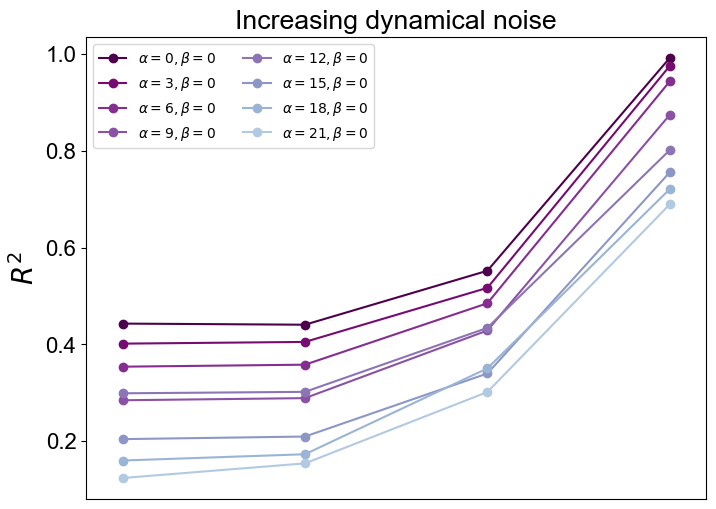

In [11]:
line_colors = generate_color_gradient(len(subjects)+3,'jrgeco')
fig, ax = plt.subplots(figsize=(8,6))

labels = [r'$\alpha=0,\beta=0$',r'$\alpha=3,\beta=0$',r'$\alpha=6,\beta=0$',r'$\alpha=9,\beta=0$',r'$\alpha=12,\beta=0$',r'$\alpha=15,\beta=0$',r'$\alpha=18,\beta=0$',r'$\alpha=21,\beta=0$']

for i in range(scores.shape[0]):
    plt.plot(scores[i,:].T,  markersize=12, marker = '.', color=line_colors[i], label=labels[i])
    
ax.set_xticks([])
ax.set_xlim([-.2,3.2])

ax.legend(fontsize=10,ncol=2)
ax.set_ylabel('$R^2$', fontsize=20)
plt.title('Increasing dynamical noise')

plt.savefig(figdir + '/lorenz_r2_alphas.pdf', dpi=300, transparent=True)

plt.show()

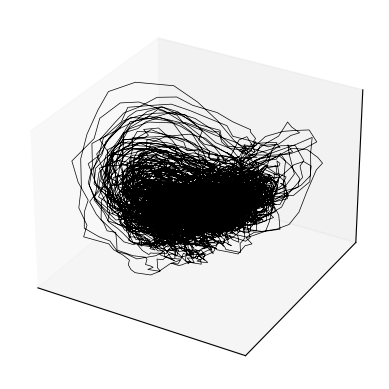

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(sim[:,0], sim[:,1], sim[:,2], lw=0.5, c='k')
# ax.set_xlabel("$z_1$")
# ax.set_ylabel("$z_2$")
# ax.set_zlabel("$z_3$")

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.savefig(figdir + '/lorenz_3d_alpha21_beta0.pdf', dpi=300, transparent=True)

plt.show()

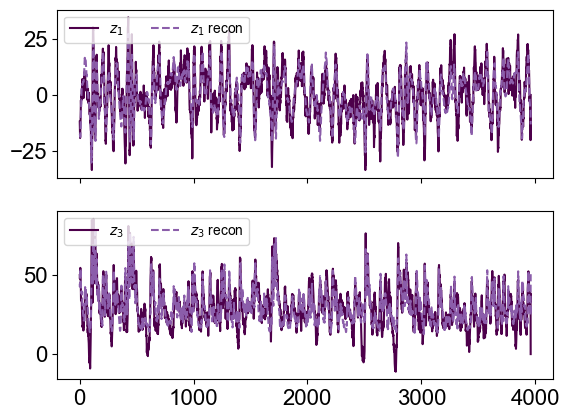

In [13]:
colors = plt.cm.BuPu_r(np.linspace(0,1,4))

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(ytest[:,0], color=colors[0],label='$z_1$')
ax1.plot(ytest_hat[:,0], color=colors[1], linestyle='--',label='$z_1$ recon')
ax2.plot(ytest[:,1], color=colors[0],label='$z_3$')
ax2.plot(ytest_hat[:,1], color=colors[1], linestyle='--', label='$z_3$ recon')

ax1.legend(fontsize=10,ncol=2,loc='upper left')
ax2.legend(fontsize=10,ncol=2,loc='upper left')

plt.savefig(figdir + '/lorenz_recons_alphas.pdf', dpi=300, transparent=True)

plt.show()

## "Observation" noise

In [14]:
nsamples = 6000
num_runs = 8

subjects = np.tile([0., 1., 1.], (num_runs, 1))

scores = np.zeros([len(subjects),4])

for s in range(num_runs):
    
    tic()
    
    alpha_param = 0#*s
    beta_param = 3*s

    t = np.linspace(0.0, dt*num_steps, num_steps)
    x0 = np.array([0., 1., 1.])

    sim = itoEuler(lorenz, G, subjects[s,:], t, omega=alpha_param) + np.random.normal(scale=beta_param, size=sim.shape)
        
    x = sim[:,1:2] # z2
    y = sim[:,[0,2]] # z1 & z3
    
    for m in range(4):
        if m==0:
            delay = 0
            nonlinear = 0
        elif m==1:
            delay = 0
            nonlinear = 1
        elif m==2:
            delay = 1
            nonlinear = 0
        else:
            delay = 1
            nonlinear = 1
    
        # Train-test split
        xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=x.shape[0]-nsamples,shuffle=False)
        
        # Time delay embedding    
        polys = legendre_polys(r, stackmax)

        H_train = hankel_matrix(xtrain.T,stackmax,spacing)
        H_test = hankel_matrix(xtest.T,stackmax,spacing)

        xtrain = H_train.T@polys
        xtest = H_test.T@polys

        xtrain = np.concatenate((xtrain,H_train.T[:,-1:]), axis=1)
        xtest = np.concatenate((xtest,H_test.T[:,-1:]), axis=1)
        
        ytrain = ytrain[spacing*(stackmax-1):,:]
        ytest = ytest[spacing*(stackmax-1):,:]

        if not delay:
            xtrain = xtrain[:,-1:]
            xtest = xtest[:,-1:]
        
        # Preprocessing    
        xtrain_sc, scale_x = scaler(xtrain)
        ytrain_sc, scale_y = scaler(ytrain)

        # Train model
        if nonlinear:
            r_squared, model, encoder, decoder = VAE(xtrain_sc, ytrain_sc, latent_dim=z_n, beta=beta, num_epochs=num_epochs, anneal_step=anneal_step, lr=lr, verbose=False)
        else:
            r_squared, model = linear_regression(xtrain_sc, ytrain_sc)

        # Test model
        xtest_sc,_ = scaler(xtest, scale_x)
        ytest_sc,_ = scaler(ytest, scale_y)
        ytest = scale_y.inverse_transform(ytest_sc)

        ytest_hat_sc = model.predict(xtest_sc)
        ytest_hat = scale_y.inverse_transform(ytest_hat_sc)
        
        scores[s,m] = r2_score(ytest, ytest_hat, multioutput = 'variance_weighted')

    toc()
    

Elapsed time is 14.289713859558105 seconds.
Elapsed time is 14.225790023803711 seconds.
Elapsed time is 14.215161323547363 seconds.
Elapsed time is 14.222937107086182 seconds.
Elapsed time is 14.134052515029907 seconds.
Elapsed time is 14.563259363174438 seconds.
Elapsed time is 14.267342329025269 seconds.
Elapsed time is 14.198634147644043 seconds.


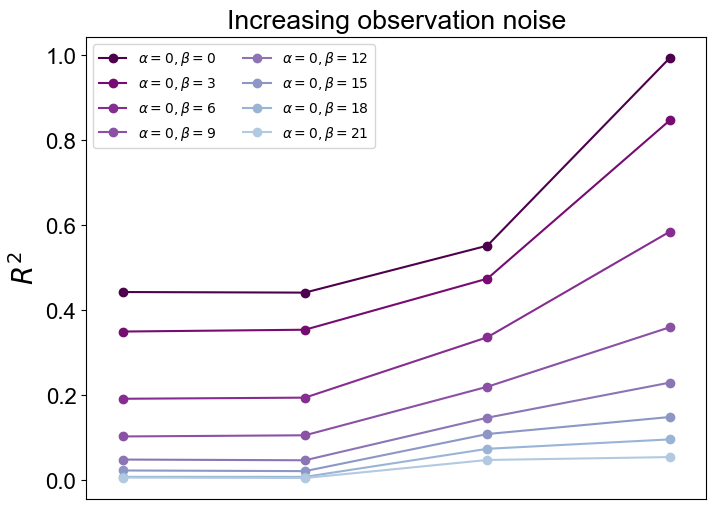

In [15]:
line_colors = generate_color_gradient(len(subjects)+3,'jrgeco')
fig, ax = plt.subplots(figsize=(8,6))

labels = [r'$\alpha=0,\beta=0$',r'$\alpha=0,\beta=3$',r'$\alpha=0,\beta=6$',r'$\alpha=0,\beta=9$',r'$\alpha=0,\beta=12$',r'$\alpha=0,\beta=15$',r'$\alpha=0,\beta=18$',r'$\alpha=0,\beta=21$']

for i in range(scores.shape[0]):
    plt.plot(scores[i,:].T,  markersize=12, marker = '.', color=line_colors[i], label=labels[i])
    
ax.set_xticks([])
ax.set_xlim([-.2,3.2])
ax.set_ylabel('$R^2$', fontsize=20)
ax.legend(fontsize=10,ncol=2)
plt.title('Increasing observation noise')

plt.savefig(figdir + '/lorenz_r2s_betas.pdf', dpi=300, transparent=True)

plt.show()

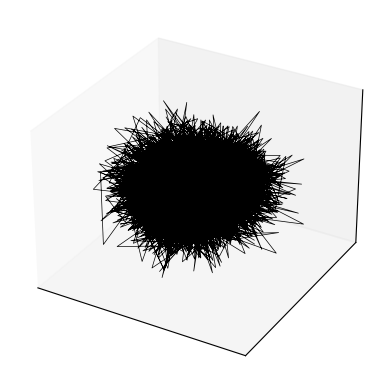

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(sim[:,0], sim[:,1], sim[:,2], lw=0.5, c='k')
# ax.set_xlabel("$z_1$")
# ax.set_ylabel("$z_2$")
# ax.set_zlabel("$z_3$")

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.savefig(figdir + '/lorenz_3d_alpha0_beta21.pdf', dpi=300, transparent=True)

plt.show()

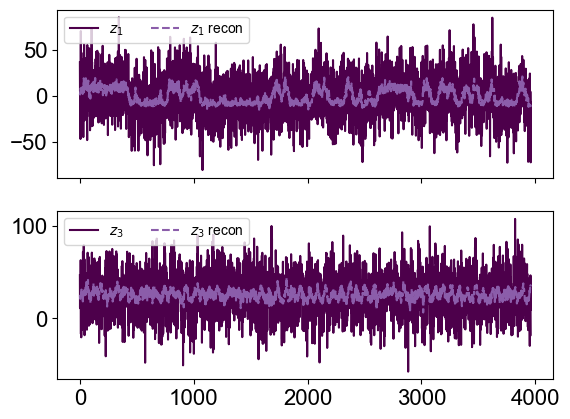

In [17]:
colors = plt.cm.BuPu_r(np.linspace(0,1,4))

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(ytest[:,0], color=colors[0],label='$z_1$')
ax1.plot(ytest_hat[:,0], color=colors[1], linestyle='--',label='$z_1$ recon')
ax2.plot(ytest[:,1], color=colors[0],label='$z_3$')
ax2.plot(ytest_hat[:,1], color=colors[1], linestyle='--', label='$z_3$ recon')

ax1.legend(fontsize=10,ncol=2,loc='upper left')
ax2.legend(fontsize=10,ncol=2,loc='upper left')

plt.savefig(figdir + '/lorenz_recons_betas.pdf', dpi=300, transparent=True)

plt.show()